# Import Modules


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime

from sklearn.preprocessing import LabelEncoder

# Load Data

In [2]:
item_cat = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
sales_train = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')


In [3]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# Exploratory Data Analysis

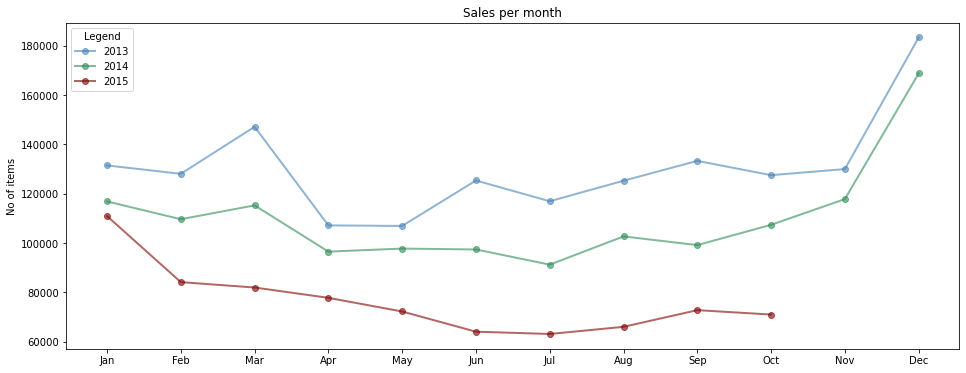

In [6]:
# Extract year and month data from the date column
sales_train["date"] = sales_train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train.drop(['date'], axis=1, inplace=True)

# Sum the number of sold items for each date_block_num (which is the consecutive month number from January 2013 to October 2015)
group = sales_train.groupby('date_block_num').agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)
group.reset_index(inplace=True)

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
LINEWIDTH=2
ALPHA=.6
plt.figure(figsize= (16,6))
#plot the Sales per month for each year
plt.plot(MONTHS, group[group.year==2013].item_cnt_month , '-o', color='steelblue', linewidth=LINEWIDTH, alpha=ALPHA,label='2013')
plt.plot(MONTHS, group[group.year==2014].item_cnt_month , '-o', color='seagreen', linewidth=LINEWIDTH, alpha=ALPHA,label='2014')
plt.plot(MONTHS[:10], group[group.year==2015].item_cnt_month , '-o', color='maroon', linewidth=LINEWIDTH, alpha=ALPHA,label='2015')

ax = plt.gca()
ax.set_title('Sales per month')
ax.set_ylabel('No of items')
plt.legend(loc=2, title='Legend')
plt.show()


<AxesSubplot:xlabel='item_price'>

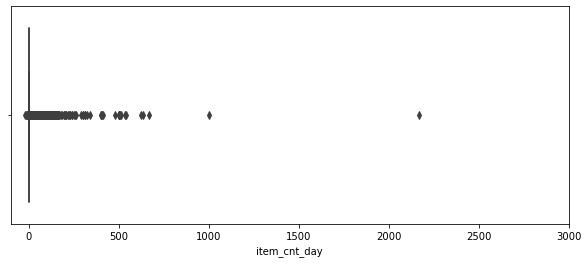

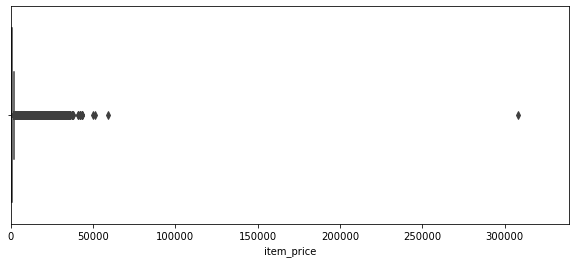

In [7]:
# plot boxplot to check for outliers in item_price and item_cnt_day
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x= sales_train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.1)
sns.boxplot(x= sales_train.item_price)

# Data Preparation

In [8]:

from itertools import product
train = []
cols = ['date_block_num','shop_id','item_id' ]
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    train.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
train = pd.DataFrame(np.vstack(train), columns=cols)
train['date_block_num'] = train['date_block_num'].astype(np.int8)
train['shop_id'] = train['shop_id'].astype(np.int8)
train['item_id'] = train['item_id'].astype(np.int16)
train.sort_values(cols,inplace=True)

In [9]:
train = pd.merge(train, sales_train, on = cols, how = 'left').fillna(0)

In [10]:
# remove outliers from item_price and item_cnt_day columns
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

# Feature Engineering

In [11]:
item_cat['split'] = item_cat['item_category_name'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x:x[0].strip() )
item_cat['subtype'] = item_cat['split'].map(lambda x:   x[1].strip() + x[2].strip() if len(x) > 2 else x[1].strip()if len(x) > 1 else x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id','type_code', 'subtype_code']]

In [12]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [13]:
train = pd.merge(train, shops, on=['shop_id'], how='left')

train = pd.merge(train, items, on=['item_id'], how='left')
train = pd.merge(train, item_cat, on=['item_category_id'], how='left')
train['item_category_id'] = train['item_category_id'].astype(np.int8)
train['type_code'] = train['type_code'].astype(np.int8)
train['subtype_code'] = train['subtype_code'].astype(np.int8)

In [14]:
train['month'] = train['date_block_num'] % 12

In [15]:
train['total_item_sales'] = train['item_price']* train['item_cnt_day']

In [16]:
train.drop([ 'year'], axis = 1, inplace = True)

In [17]:
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

train = pd.merge(train, group, on=cols, how='left')
train['item_cnt_month'] = (train['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) 
                                .astype(np.float16))

In [18]:
group = train.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

train = pd.merge(train, group, on=['date_block_num'], how='left')
train['date_avg_item_cnt'] = train['date_avg_item_cnt'].astype(np.float16)

In [19]:
train["avg_item_cnt"] = train["item_cnt_day"].rolling(window = 3).mean().fillna(0)


In [20]:
def lag_feature(df, lag_list, col):
    for lag in lag_list:
        ft_name = col+"_lag_"+str(lag)
        df[ft_name] = train.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])[col].shift(lag)
        df[ft_name].fillna(0, inplace=True)
    return df

In [21]:
train = lag_feature(train, [1, 2, 3], 'item_cnt_month')

# Mean Encoded Features

In [22]:
group = train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

train = pd.merge(train, group, on=['date_block_num','item_id'], how='left')
train['date_item_avg_item_cnt'] = train['date_item_avg_item_cnt'].astype(np.float16)
train = lag_feature(train, [1,2,3,6,12], 'date_item_avg_item_cnt')

In [23]:
group = train.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

train = pd.merge(train, group, on=['date_block_num','shop_id'], how='left')
train['date_shop_avg_item_cnt'] = train['date_shop_avg_item_cnt'].astype(np.float16)
train = lag_feature(train, [1,2,3,6,12], 'date_shop_avg_item_cnt')

In [24]:
group = train.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

train = pd.merge(train, group, on=['date_block_num','item_category_id'], how='left')
train['date_cat_avg_item_cnt'] = train['date_cat_avg_item_cnt'].astype(np.float16)
train = lag_feature(train, [1], 'date_cat_avg_item_cnt')

In [25]:
group = train.groupby(["date_block_num","type_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace = True)

train = pd.merge(train, group, on=['date_block_num', 'type_code'], how='left')
train['date_type_avg_item_cnt'] = train['date_type_avg_item_cnt'].astype(np.float16)
train = lag_feature(train, [1], 'date_type_avg_item_cnt')

In [26]:
group = train.groupby(["date_block_num", "subtype_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["date_subtype_avg_item_cnt"]
group.reset_index(inplace = True)

train = pd.merge(train, group, on=['date_block_num', 'subtype_code'], how='left')
train = lag_feature(train, [1], "date_subtype_avg_item_cnt")

In [27]:
group = train.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
train = pd.merge(train, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
train['date_item_city_avg_item_cnt'] = train['date_item_city_avg_item_cnt'].astype(np.float16)
train = lag_feature(train, [1], 'date_item_city_avg_item_cnt')

In [28]:
train.drop(['item_name','date_item_avg_item_cnt','date_shop_avg_item_cnt','date_cat_avg_item_cnt','date_type_avg_item_cnt',"date_subtype_avg_item_cnt",'date_item_city_avg_item_cnt'], axis = 1, inplace = True)

In [29]:
train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day',
       'month', 'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'total_item_sales', 'item_cnt_month', 'date_avg_item_cnt',
       'avg_item_cnt', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1'],
      dtype='object')

In [30]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,city_code,item_category_id,type_code,subtype_code,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
0,0,0,19,0.0,0.0,0,0,40,11,6,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0,0,27,0.0,0.0,0,0,19,5,12,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,0,0,28,0.0,0.0,0,0,30,8,57,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0,0,29,0.0,0.0,0,0,23,5,18,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0,0,32,221.0,2.0,0,0,40,11,6,...,0.0,2.398438,2.398438,2.398438,0.0,0.0,1.011719,0.861328,1.011719,6.601562


# Data Split

In [31]:
X_train = train[train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = train[train.date_block_num < 33]['item_cnt_month']
X_valid = train[train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train[train.date_block_num == 33]['item_cnt_month']
X_test = train[train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# XGBoost

In [32]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 100, seed = 42)
xg_reg.fit(X_train,Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)],eval_metric="rmse",early_stopping_rounds = 10 )

preds = xg_reg.predict(X_test)